In [1]:
from cnn import *

2025-05-13 16:48:38.661349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 16:48:38.666463: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 16:48:38.679137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747180118.699799 1718552 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747180118.705987 1718552 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747180118.722266 1718552 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# particle_types = ['e+', 'e-', 'pi+', 'pi-']
particle_types = ['e-', 'pi-']
energy_ranges = ['E1-100', 'E30-70']
# energy_ranges = ['E1-100']

beamE_list = []
hist2d_data_list = []
esum_list = []
particles_type_list = []
data_shape = None

for i, particle in enumerate(particle_types):
    for energy_range in energy_ranges:
        file_path = f'{particle}_{energy_range}_2000.h5'
        group_name = f'{particle}_{energy_range}_2000'
        beamE, hist2d_data, esum, shape = load_data(file_path, group_name)
  
        beamE_list.append(beamE)
        hist2d_data_list.append(hist2d_data)
        esum_list.append(esum)
        
        particles_type_list.append(np.full(beamE.shape[0], i))
        data_shape = shape  

beamE = np.concatenate(beamE_list, axis=0)
hist2d_data = np.concatenate(hist2d_data_list, axis=0)
esum = np.concatenate(esum_list, axis=0)
particles_type = np.concatenate(particles_type_list, axis=0)

scaler = StandardScaler()
esum = scaler.fit_transform(esum.reshape(-1, 1)).flatten()

labels_particle = tf.keras.utils.to_categorical(particles_type, num_classes=4)

height, width = data_shape
hist2d_data = hist2d_data.reshape((-1, height, width, 1))

(train_beamE, train_hist2d_data, train_esum, train_labels_particle), \
(val_beamE, val_hist2d_data, val_esum, val_labels_particle), \
(test_beamE, test_hist2d_data, test_esum, test_labels_particle) = split_data(beamE, hist2d_data, esum, labels_particle)

input_shape = (height, width, 1)

2025-05-13 16:48:49.487852: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 9.3188 - output_energy_loss: 8.7180 - output_energy_mae: 50.1894 - output_particle_accuracy: 0.8271 - output_particle_auc: 0.9343 - output_particle_loss: 0.6005 - val_loss: 11.8590 - val_output_energy_loss: 11.1036 - val_output_energy_mae: 55.0668 - val_output_particle_accuracy: 0.6485 - val_output_particle_auc: 0.9135 - val_output_particle_loss: 0.7549 - learning_rate: 0.0010
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 4.5865 - output_energy_loss: 4.3923 - output_energy_mae: 48.8951 - output_particle_accuracy: 0.9546 - output_particle_auc: 0.9896 - output_particle_loss: 0.1943 - val_loss: 3.3036 - val_output_energy_loss: 2.7736 - val_output_energy_mae: 42.3915 - val_output_particle_accuracy: 0.9137 - val_output_particle_auc: 0.9607 - val_output_particle_loss: 0.5297 - learning_rate: 0.0010
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 3.2458 - output_energy_loss: 3.0725 - output_energy_mae: 46.3669

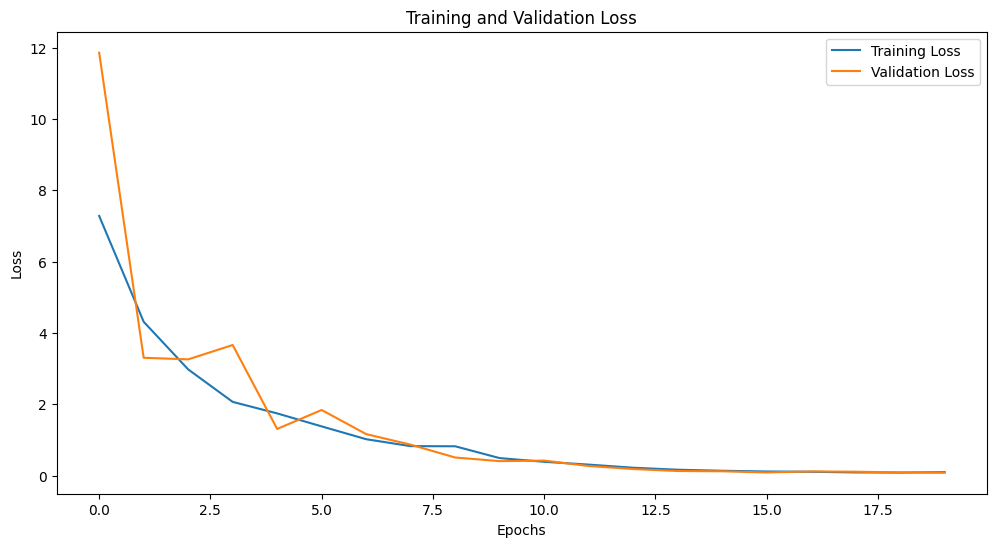

In [3]:

train_data = ([train_hist2d_data, train_esum], [train_labels_particle, train_beamE.reshape((-1, 1))])
val_data = ([val_hist2d_data, val_esum], [val_labels_particle, val_beamE.reshape((-1, 1))])
test_data = ([test_hist2d_data, test_esum], [test_labels_particle, test_beamE.reshape((-1, 1))])

best_model = train_until_convergence(train_data, val_data, test_data, input_shape, epochs_per_round=20)




25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1063 - output_energy_loss: 0.0886 - output_energy_mae: 12.4893 - output_particle_accuracy: 0.9954 - output_particle_auc: 0.9999 - output_particle_loss: 0.0177
Test Loss: 0.10497062653303146, Test Particle Accuracy: 0.01369821559637785, Test Energy MAE: 0.09127241373062134
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test Particle Type Accuracy: 0.99625


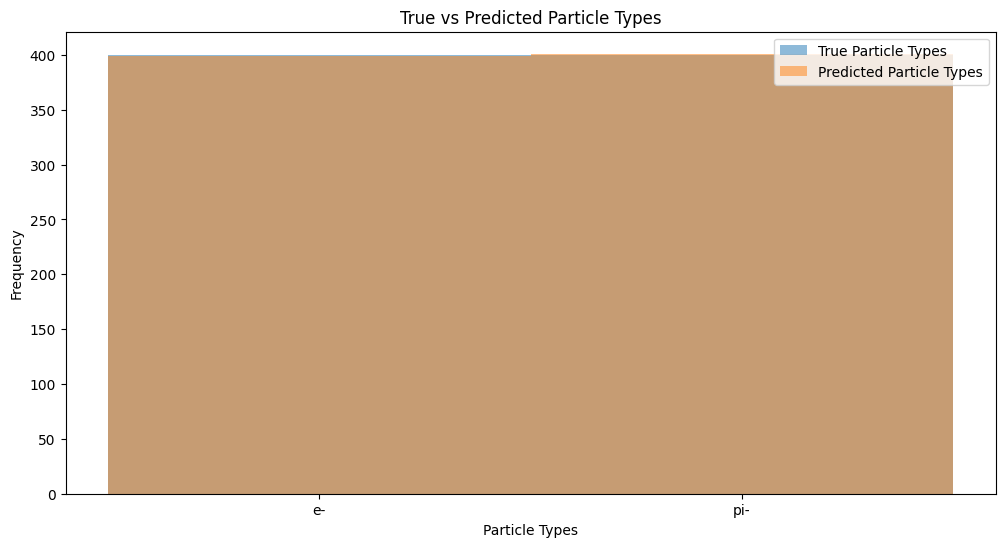

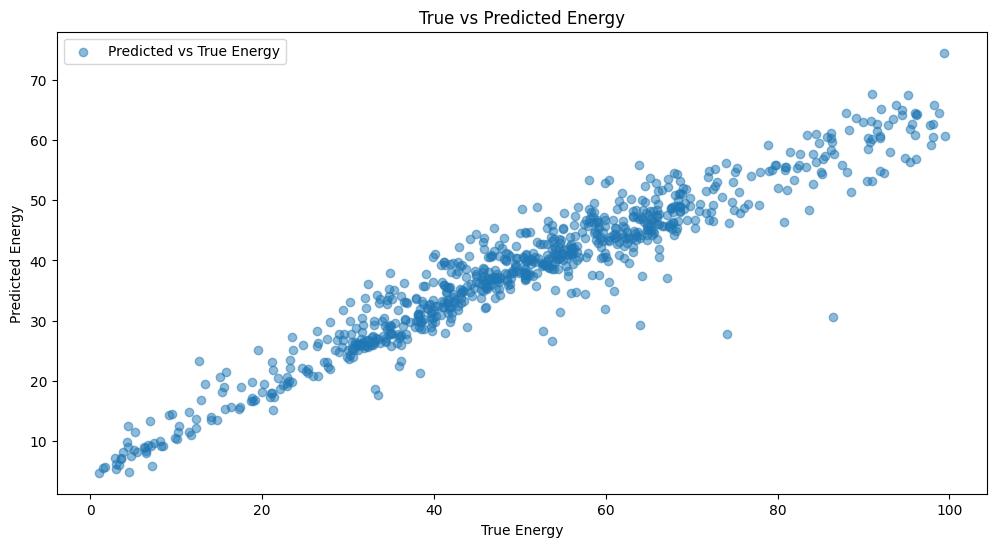

In [6]:
# predicted_energy_scaled = best_model.predict(test_data[0])[1]
# predicted_energy = scaler.inverse_transform(predicted_energy_scaled)

predicted_energy = best_model.predict(test_data[0])[1]

loss, acc_particle, mae_energy, a, b ,c= best_model.evaluate(test_data[0], test_data[1])
print(f'Test Loss: {loss}, Test Particle Accuracy: {acc_particle}, Test Energy MAE: {mae_energy}')

predictions_particle, _ = best_model.predict(test_data[0])
predictions_particle_classes = np.argmax(predictions_particle, axis=1)

particle_accuracy = np.mean(predictions_particle_classes == np.argmax(test_data[1][0], axis=1))
print(f'Test Particle Type Accuracy: {particle_accuracy}')

# particle_labels = ['e+', 'e-', 'pi+', 'pi-']
particle_labels = ['e-', 'pi-']
true_labels = np.argmax(test_data[1][0], axis=1)
plt.figure(figsize=(12, 6))
plt.hist(true_labels, bins=np.arange(len(particle_labels) + 1) - 0.5, alpha=0.5, label='True Particle Types')
plt.hist(predictions_particle_classes, bins=np.arange(len(particle_labels) + 1) - 0.5, alpha=0.5, label='Predicted Particle Types')
plt.xlabel('Particle Types')
plt.ylabel('Frequency')
plt.xticks(np.arange(len(particle_labels)), particle_labels)
plt.legend()
plt.title('True vs Predicted Particle Types')
plt.savefig('particle_types_histogram.png')

plt.figure(figsize=(12, 6))
plt.scatter(test_data[1][1], predicted_energy, alpha=0.5, label='Predicted vs True Energy')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.legend()
plt.title('True vs Predicted Energy')
plt.savefig('energy_scatter.png')

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_particle_predictions(model, test_data, particle_labels, particle_idx):
    """
    Plots a histogram of predicted particle types for a test set filtered to a single true class.
    
    Arguments:
    - model: Trained Keras model that outputs [particle_probs, energy_pred].
    - test_data: Tuple ([hist2d_data, esum], [labels_onehot, energies]).
    - particle_labels: List of class names, e.g. ['e-', 'pi-'].
    - particle_idx: Integer index of the true class to filter on.
    """
    # Extract test inputs and true labels
    test_hist2d_data, test_esum = test_data[0]
    test_labels_onehot = test_data[1][0]
    
    # Build mask for the chosen true class
    true_particles = np.argmax(test_labels_onehot, axis=1)
    mask = (true_particles == particle_idx)
    
    # Filter inputs
    hist2d_subset = test_hist2d_data[mask]
    esum_subset   = test_esum[mask]
    
    # Predict particle probabilities and classes
    pred_probs = model.predict([hist2d_subset, esum_subset])[0]
    pred_classes = np.argmax(pred_probs, axis=1)
    
    # Plot histogram of predicted classes
    plt.figure(figsize=(6,4))
    plt.hist(pred_classes, bins=np.arange(len(particle_labels)+1)-0.5, rwidth=0.8)
    plt.xticks(np.arange(len(particle_labels)), particle_labels)
    plt.xlabel('Predicted Particle Type')
    plt.ylabel('Count')
    plt.title(f'Predictions for True Particle = {particle_labels[particle_idx]}')
    plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


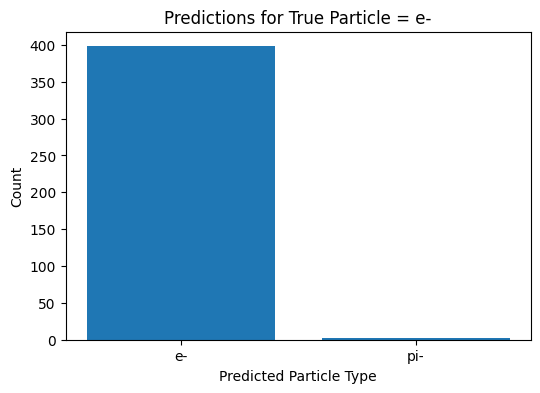

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


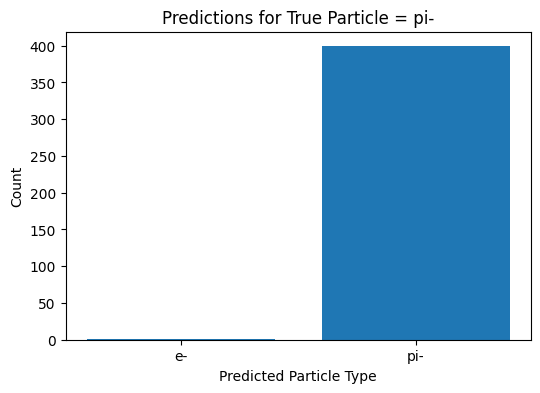

In [8]:
particle_labels = ['e-', 'pi-']
# Plot predictions for true e- events (index 0)
plot_single_particle_predictions(best_model, test_data, particle_labels, 0)

# Plot predictions for true pi- events (index 1)
plot_single_particle_predictions(best_model, test_data, particle_labels, 1)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


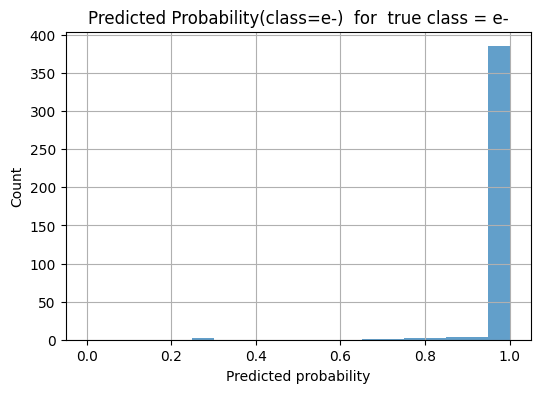

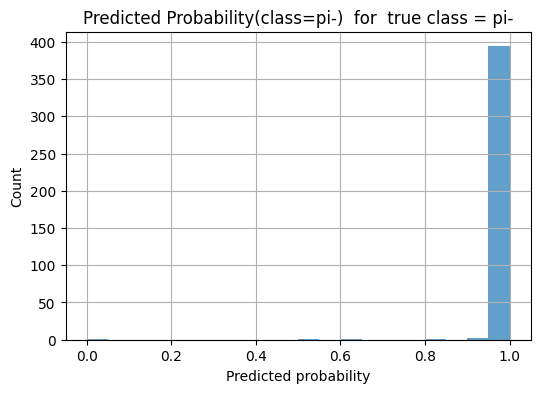

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) (Re-)load your best model if you need to
best_model = tf.keras.models.load_model('best_model.keras')

# 2) Unpack your test split
#    (after your split_data call you should still have these in memory)
# test_hist2d_data, test_esum = test_data[0]
# test_labels_particle, _      = test_data[1]

particle_labels = ['e-', 'pi-']  # adjust to your classes

# 3) Run prediction on the whole test set
pred_probs = best_model.predict([test_hist2d_data, test_esum])[0]
#    pred_probs.shape == (N_test, num_classes)

# 4) Determine the true class index per example
true_idx = np.argmax(test_labels_particle, axis=1)

# 5) For each true class, plot histogram of the predicted probability assigned to that class
for cls, name in enumerate(particle_labels):
    mask = (true_idx == cls)
    probs_for_true = pred_probs[mask, cls]
    
    plt.figure(figsize=(6,4))
    plt.hist(probs_for_true, bins=20, range=(0,1), alpha=0.7)
    plt.title(f"Predicted Probability(class={name})  for  true class = {name}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/sdf/home/q/qihuaw/.venv/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/sdf/home/q/qihuaw/.venv/lib64/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


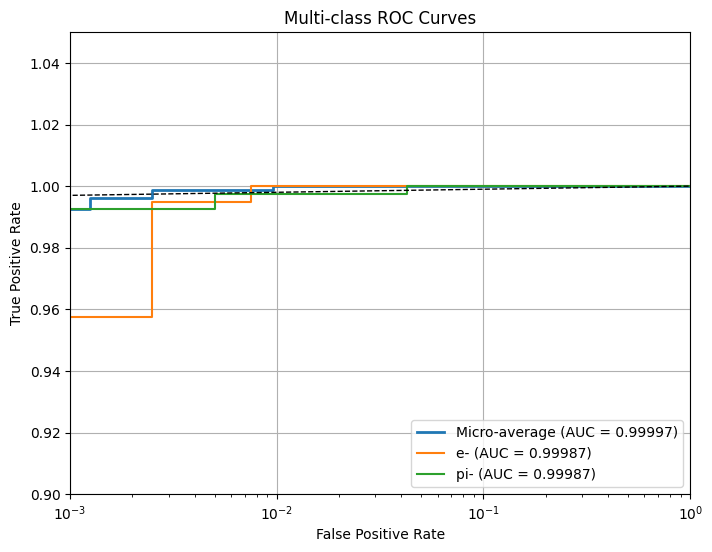

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1) Re-compute your test true labels and predicted probabilities:
#    - test_data[0] = [test_hist2d_data, test_esum]
#    - test_data[1] = [test_labels_particle_onehot, test_beamE]
y_true = test_data[1][0]                    # shape (N_test, C)
y_score = best_model.predict(test_data[0])[0]  # shape (N_test, C)

particle_labels = ['e-', 'pi-']  # adjust to your class names
n_classes = y_true.shape[1]

# 2) Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3) Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4) Plot everything
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.5f})', lw=2)

for i, lbl in enumerate(particle_labels):
    plt.plot(fpr[i], tpr[i],
             label=f'{lbl} (AUC = {roc_auc[i]:.5f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim(1e-3,1)
plt.xscale('log')
plt.ylim(0.9,1.05)
# plt.yscale("log")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
